In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/DataAir/'

Mounted at /content/drive


# Setup

In [2]:
#replacing missing values with 0 
contents = pd.read_csv(path+'DataAirTrain.csv')
contents.drop(['Unnamed: 0', 'Unnamed: 0.1', 'time'], axis=1, inplace=True)
contents.fillna(0, inplace=True)
cols = contents.columns

In [3]:
# series = 1 column 
# name = name of column 
def visualization(series, name):
  len = series.size
  x = np.arange(len)
  y = series.to_numpy()
  plt.figure(figsize=(10, 3))
  # visualization for 240 first hours 
  plt.plot(x[:240], y[:240])
  plt.title(name)
  plt.show()

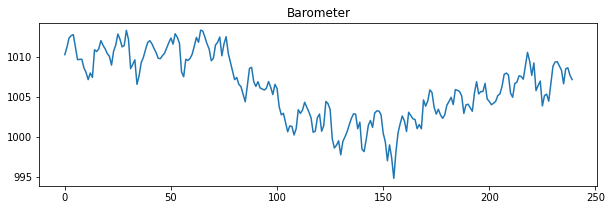

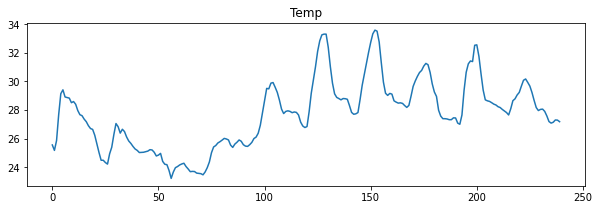

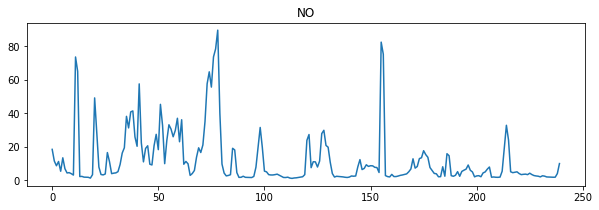

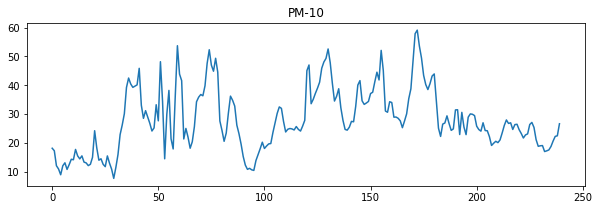

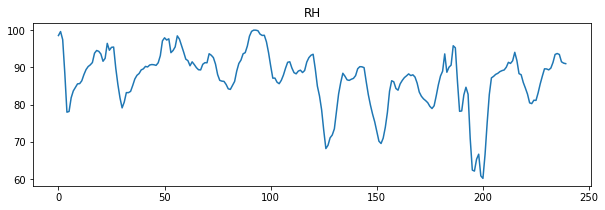

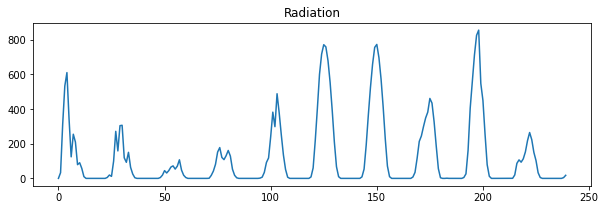

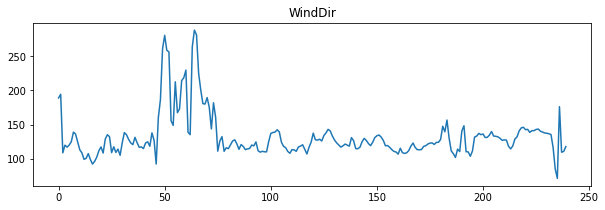

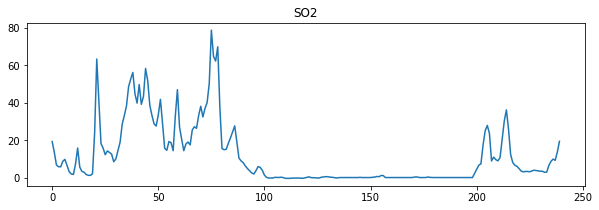

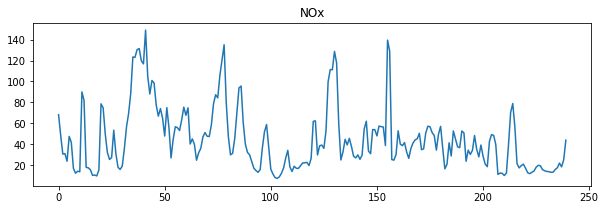

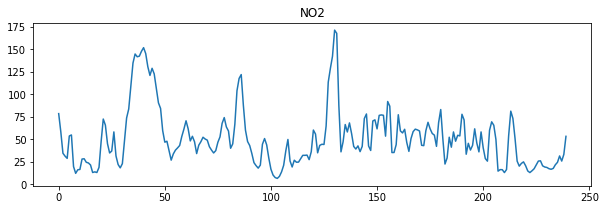

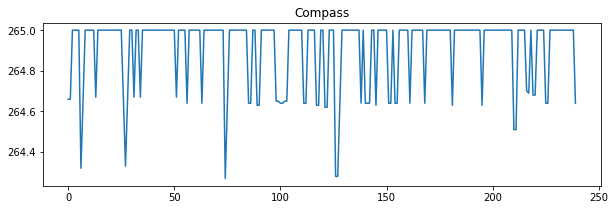

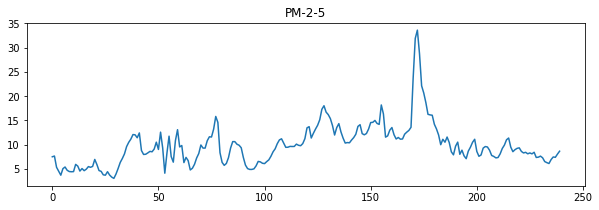

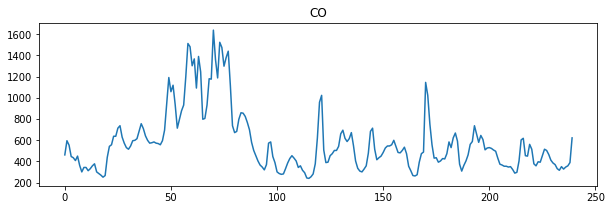

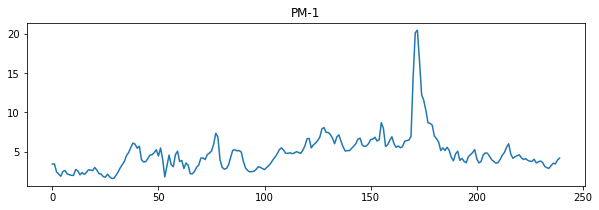

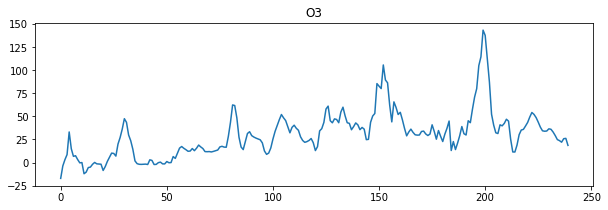

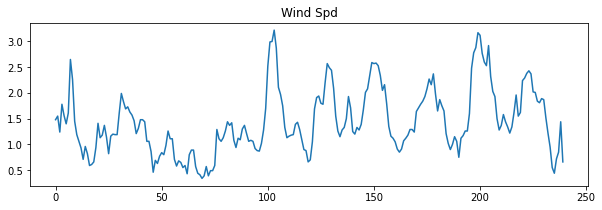

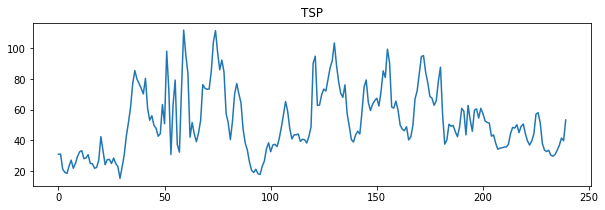

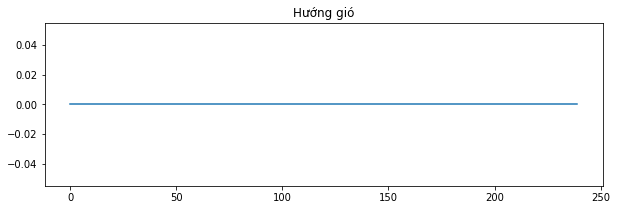

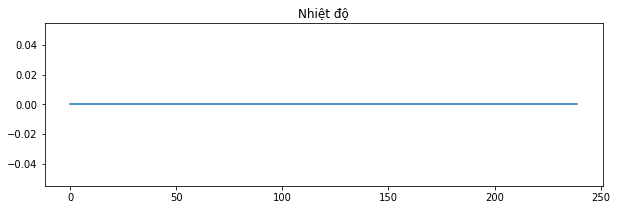

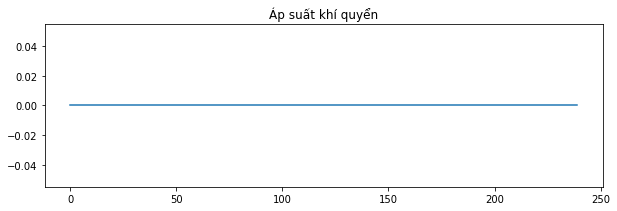

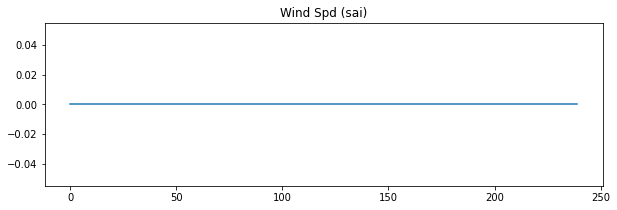

In [4]:
for col in cols:
  visualization(contents[col], col)

# Univariate

In [5]:
# using only PM-10 to predict future PM-10 
pm10_data = contents['PM-10'].values.reshape(-1, 1)
# scale to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_pm10_data = scaler.fit_transform(pm10_data)

In [6]:

def gen_dataset(series):
  window_size = 168 # using 72 previous hours to predict the following hour 
  predict_size = 48 # predict 48 following hours
  X = [] # X - data input (data of 72 previous hours )
  Y = [] # Y - the following hour (true data) 
  for i in range(window_size, series.size-predict_size+1, predict_size):
    X.append(series[i-window_size:i,:])
    Y.append(series[i:i+predict_size,:])
  
  return np.array(X), np.array(Y)

In [7]:
X, Y = gen_dataset(scaled_pm10_data)
print(X.shape, Y.shape)
# 0.8 for training data set, 0.2 for test data
# using an avaliable train_test_split function in sklearn 
# shuffle = False --> put all data in order 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False)
print(X_train.shape, Y_train.shape)

(67, 168, 1) (67, 48, 1)
(53, 168, 1) (53, 48, 1)


In [8]:
# build model 
def lstm_model(X_train):
  model = Sequential()
  # 5 layers include: 3 LSTM layers, 2 Dense layers
  model.add(LSTM(units = 30, return_sequences = True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(units = 30, return_sequences = True, activation='relu'))
  model.add(LSTM(units = 30, activation='relu'))
  model.add(Dense(units = 30, activation='relu'))
  # model.add(Dense(units = 64, activation='relu'))
  model.add(Dense(units = 48)) # predict 48 following hours
 # optimization neurol network using Adam optimizer library   
  model.compile(optimizer = Adam(learning_rate=0.001, weight_decay=0.0001), loss = 'mean_squared_error') 
  # model.compile(optimizer = Adam(learning_rate=0.001, weight_decay=0.001), loss = 'mean_absolute_error')
  # model.compile(optimizer = Adam(learning_rate=0.001, weight_decay=0.001), loss = 'mean_absolute_percentage_error')
  model.summary()

  return model

In [9]:
model = lstm_model(X_train)
print(X_train.shape, Y_train.shape)
# using EarlyStopping to prevent from overfitting 
callback = EarlyStopping(monitor = 'val_loss', min_delta = 1e-5, patience = 10, mode = 'min')
hist = model.fit(X_train,
                 Y_train,
                 epochs=1000, # numbers of loops
                 batch_size=512,
                 shuffle=True, 
                 validation_split=0.2,
                 verbose=1,
                 callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 30)           3840      
                                                                 
 lstm_1 (LSTM)               (None, 168, 30)           7320      
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 48)                1488      
                                                                 
Total params: 20,898
Trainable params: 20,898
Non-trainable params: 0
_________________________________________________________________
(53, 168, 1) (53, 48, 1)
Epoch 1/1000
1/1 [=========

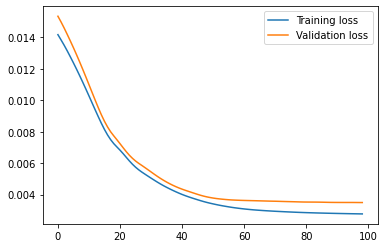

In [10]:
plt.plot(hist.history['loss'], label = 'Training loss')  
plt.plot(hist.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [11]:
Y_pred = model.predict(X_test)
Y_pred = Y_pred.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
print('MSE', mean_squared_error(Y_test, Y_pred))
print('MAE', mean_absolute_error(Y_test, Y_pred))
print('MAPE', mean_absolute_percentage_error(Y_test, Y_pred))
Y_test_restored = scaler.inverse_transform(Y_test)
Y_pred_restored = scaler.inverse_transform(Y_pred)

1/1 [==============================] - 1s 597ms/step
MSE 0.008731690161520847
MAE 0.05898187717388189
MAPE 0.44090390495643833


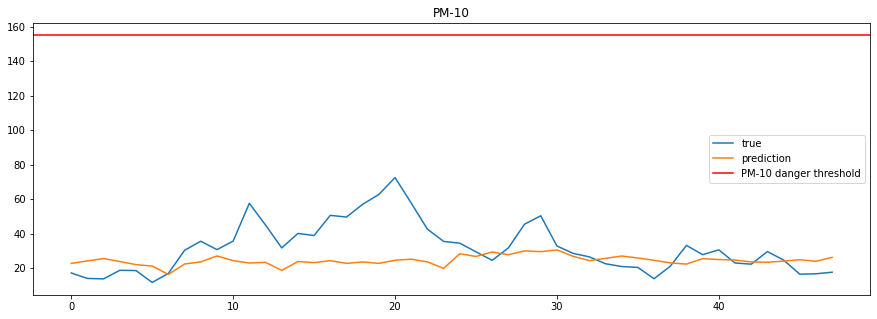

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(Y_test_restored[72:72+48], label='true')
plt.plot(Y_pred_restored[72:72+48], label='prediction')
plt.axhline(y = 155, color = 'r', label='PM-10 danger threshold') # >= 155 warning air quality 
plt.legend()
plt.title('PM-10')

plt.show()